_This notebook was written by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/ClassiPyGRB)._

# Extended Emission GRBs and t-SNE analysis

The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

In previous notebooks, we have pre-processed Swift Data to apply T-SNE and other dimensionality reduction techniques. In this notebook, we are going to analyze the results obtained in order to classify new Extended Emission GRBs. Through this document, we'll be using the _python3_ implementations from the _ClassiPyGRB_ package. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we have to import the _SWIFT_ instance of _ClassiPyGRB_ to our notebook (and some other packages needed):

In [1]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Here, it will be created two objects of the _SWIFT_ instance in _ClassiPyGRB_, each one with a different resolution. The first one is going to be used for the 64 ms data and the second one for the 10 s data:

In [2]:
swift_64ms = SWIFT(root_path=r'type-your-path-here', res=64, n_bands=[1, 2, 3, 4, 5])
swift_10s = SWIFT(root_path=r'type-your-path-here', res=10000, n_bands=[1, 2, 3, 4, 5])

# Extended Emission GRBs

In terms of GRB classification, one of the most relevant challenges involved the Extended Emission candidates: their categorization and identification. Extended emission GRBs are hybrid events with features of the both populations: They have a prompt emission featuring properties of short GRBs, followed by an extended emission tail of several seconds of duration.

We'll take advantage from other important feature of reduction algorithms as t-SNE is that they are able to group similar GRBs in the same region of the embedding. As [Garcia-Cifuentes et al.(2023)](https://arxiv.org/abs/2304.08666) demonstrated, it is possible to find Extended Emission (EE) GRBs by looking the nearest neighbors of previous categorized EE GRBs. In this notebook we are going to replicate their results using the 64 ms data (and its FABADA noise-reduced version) and the 10 s data.

To illustrate this, we look into GRB 060614 or GRB 211211A:

array([<Axes: >, <Axes: >, <Axes: ylabel='Counts/sec/det'>, <Axes: >,
       <Axes: xlabel='Time since BAT Trigger time (s)'>], dtype=object)

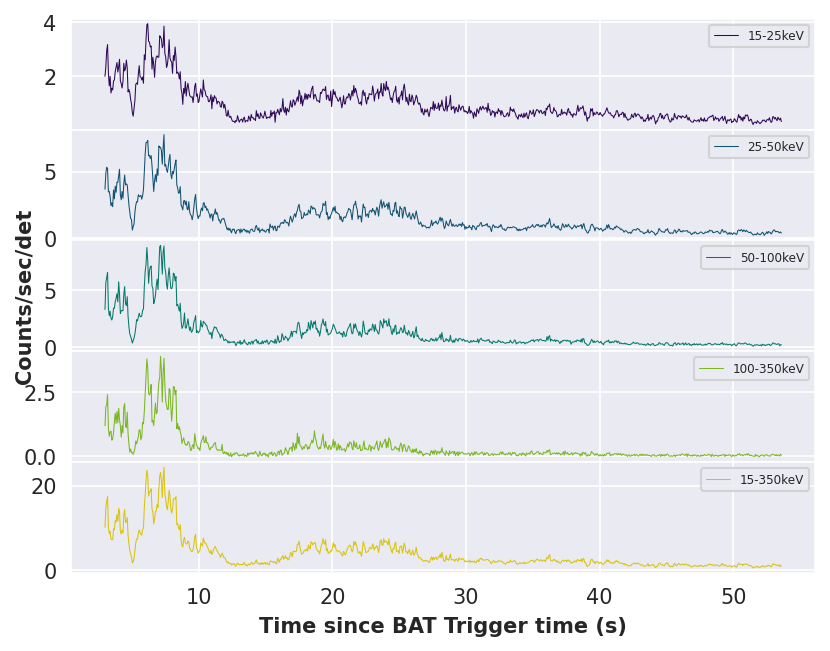

In [14]:
name = 'GRB211211A'
swift_64ms.plot_any_grb(name=name, legend=True, check_disk=True, t=90)

At this point, to check where these types of GRBs are clustered in t-SNE, it is needed to import the results in the 64 ms and 10 s data:

In [4]:
data_64ms = np.load(os.path.join(swift_64ms.results_path, f'SWIFT_data_{swift_64ms.res}res_{"".join(str(b) for b in swift_64ms.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_64ms['names'], data_64ms['data']
durations_64ms = swift_64ms.total_durations(names_64ms, t=90)

Finding Durations: 100%|██████████| 1451/1451 [00:00<00:00, 1777.11GRB/s]


In [5]:
data_fabada = np.load(os.path.join(swift_64ms.results_path, f'SWIFT_Noise_Reduced_data_{swift_64ms.res}res_{"".join(str(b) for b in swift_64ms.n_bands)}bands_DFT_True.npz'))
names_fabada, features_fabada = data_fabada['names'], data_fabada['data']
durations_fabada = swift_64ms.total_durations(names_fabada, t=90)

Finding Durations: 100%|██████████| 1451/1451 [00:00<00:00, 2305.31GRB/s]


In [6]:
resolution = 30
data_10s = np.load(os.path.join(swift_10s.results_path, f'SWIFT_data_{swift_10s.res}res_{"".join(str(b) for b in swift_10s.n_bands)}bands_DFT_True_Interpolated_at_{resolution}ms.npz'))
names_10s, features_10s = data_10s['names'], data_10s['data']
durations_10s = swift_10s.total_durations(names_10s, t=90)

Finding Durations: 100%|██████████| 1326/1326 [00:00<00:00, 2225.08GRB/s]


Perform the t-SNE analysis:

In [7]:
%%time
pos_64ms = [swift_64ms.perform_tsne(features_64ms, perplexity=pp, learning_rate=200) for pp in [5, 30]]
pos_fabada = [swift_64ms.perform_tsne(features_fabada, perplexity=pp, learning_rate=200) for pp in [5, 30]]
pos_10s = [swift_10s.perform_tsne(features_10s, perplexity=pp, learning_rate=200) for pp in [5, 30]]

CPU times: user 8min 29s, sys: 1min 47s, total: 10min 16s
Wall time: 1min 51s


Making a figure for summarizing the t-SNE results:

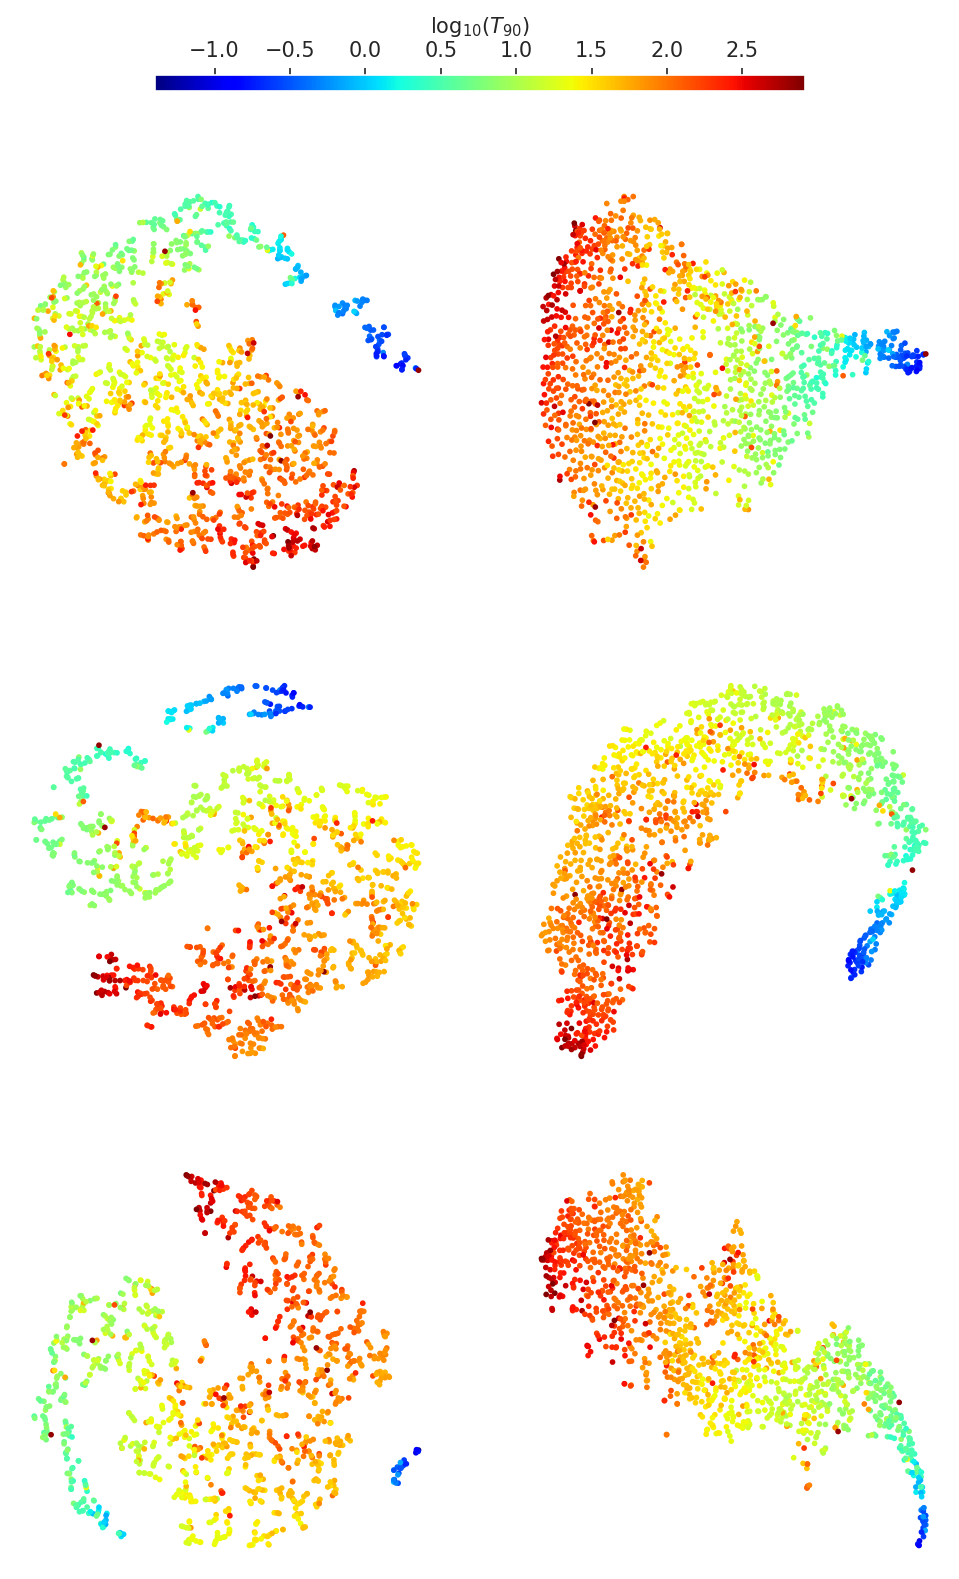

In [8]:
norm = mpl.colors.Normalize(vmin=min(np.log10(durations_10s)), vmax=max(np.log10(durations_10s)))
color_lim = np.min(np.log10(durations_10s)), np.max(np.log10(durations_10s))  # Set a standard set of durations
kwargs_plot = {"return_colorbar":True, "redshifts":None, "color_limits":color_lim, 'marker_size':3}
fig = plt.figure(figsize=[8, 15], dpi=150)
gs = fig.add_gridspec(ncols=2, nrows=3, wspace=0.2, hspace=0.2)
ax = gs.subplots()
for i in range(2):
    ax[0, i], bar = swift_64ms.plot_tsne(pos_64ms[i], durations_64ms, ax=ax[0, i], **kwargs_plot)
    bar.remove() if bar != () else None
    ax[1, i], bar = swift_64ms.plot_tsne(pos_fabada[i], durations_fabada, ax=ax[1, i], **kwargs_plot)
    bar.remove() if bar != () else None
    ax[2, i], bar = swift_10s.plot_tsne(pos_10s[i], durations_10s, ax=ax[2, i], **kwargs_plot)
    bar.remove() if bar != () else None
[ax.axis("off") for ax in ax.flatten()]
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet), ax=ax, location='top', label=r'log$_{10}\left(T_{90}\right)$', shrink=0.7, aspect=40)

Here, the first row corresponds to the 64 ms data without using the FABADA noise reducing, whereas the second row shows the 64 ms data with FABADA noise reducing and the third row to the 10 s data. The left column corresponds to the t-SNE analysis with perplexity 5 and the right column to the t-SNE analysis with perplexity 30. The color bar is the same for all the plots, so we can compare the results between them.

Talking about Extended Emission GRBs, the current classification of EE GRBs are typically based on S/N ratio in the extended emission phase, multi-wavelength analysis using data from Swift/BAT and Swift/XRT, bayesian approaches, and direct Swift image analysis. [Lien et al.(2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...829....7L/abstract) presents a detailed analysis of these GRBs in their sample of Swift/BAT light curves until 2016. This sample is based only in eye inspection of Swift/BAT data of GCN candidates. They provide a list of 12 GRBs categorized as "_Definite Extended Emission GRBs_":

In [9]:
EE_Lien16 = ['GRB150424A', 'GRB111121A', 'GRB090916', 'GRB090715A', 'GRB090531B', 'GRB080503', 'GRB071227', 'GRB070714B', 'GRB061210', 'GRB061006', 'GRB051227', 'GRB050724']

These GRBs are highlighted in the next plot by order :

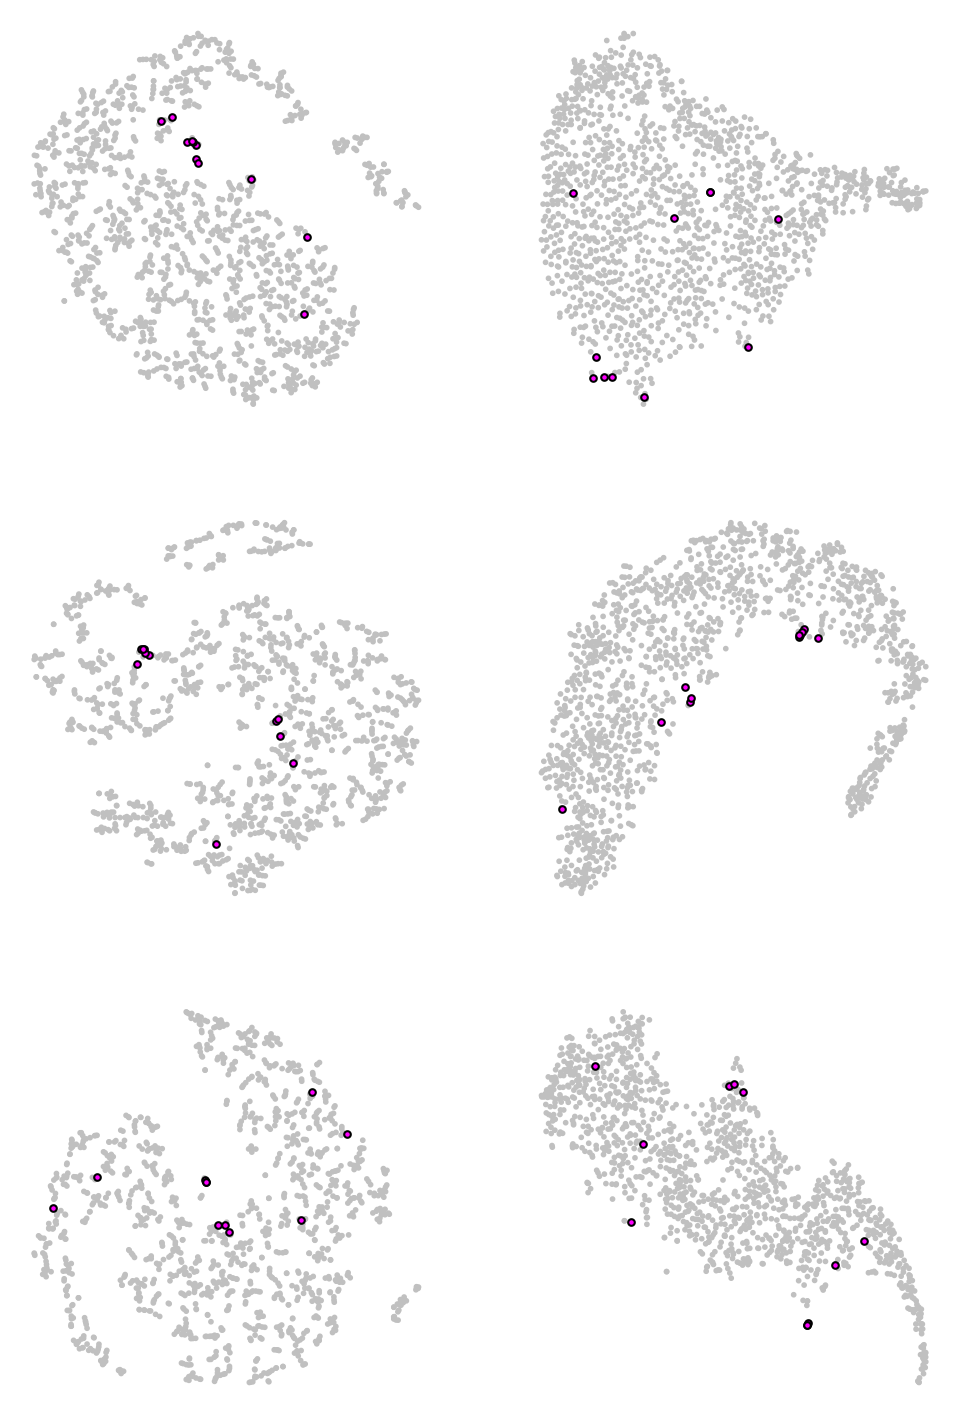

In [10]:
kwargs_plot_2= {"return_colorbar":True, "redshifts":None, "special_marker_color":"magenta", "color_limits":color_lim, "special_cases":EE_Lien16, "non_special_marker_color":'silver', "special_marker":["o"]*100, "legend_special_cases":False, 'marker_size':3, 'special_marker_size':10}
fig = plt.figure(figsize=[8, 12], dpi=150)
gs = fig.add_gridspec(ncols=2, nrows=3, wspace=0.2, hspace=0.2)
ax = gs.subplots()
[ax.axis("off") for ax in ax.flatten()]
for i in range(2):
    ax[0, i], bar = swift_64ms.plot_tsne(pos_64ms[i], durations_64ms, ax=ax[0, i], names=names_64ms ,**kwargs_plot_2)
    bar.remove() if bar != () else None
    ax[1, i], bar = swift_64ms.plot_tsne(pos_fabada[i], durations_fabada, ax=ax[1, i], names=names_fabada, **kwargs_plot_2)
    bar.remove() if bar != () else None
    ax[2, i], bar = swift_10s.plot_tsne(pos_10s[i], durations_10s, ax=ax[2, i], names=names_10s, **kwargs_plot_2)
    bar.remove() if bar != () else None

The 64 ms $perplexity =30$ embedding without any noise reduction (upper right map) does not offer any evidence of a clustering of these EE candidates. Nevertheless, with a $perplexity=5$ embedding, the EE GRBs are more clustered, particularly in the middle of the plot (where 9 out of 11 EE GRBs present here are clustered). Showing the correlation between low perplexities and the possibility to identify subgroups of GRBs with similar properties.

The FABADA noise reduced embeddings (middle maps) shows a similar result, but with a more clear clustering of EE GRBs (in two particular regions of the edges), except for one EE GRB (GRB 060614). Moreover, these groups are present both in the $perplexity=5$ and $perplexity=30$ embeddings. This is a strong evidence of the importance of the noise reduction in order to characterize substructures in Swift/BAT data. Finally, the 10 s data (lower right map) shows a similar clustering of EE GRBs, but these groups are more spread over the embedding.

We suggest this as the evidence of EE GRBs have properties of long and short GRBs. Due to this hybrid characteristics, t-SNE joins them to the most likely group (in this case the long GRB). The presence of spread EE GRBs in the embeddings can be a result of using 64ms binning data, as these data does not offer a noticeable EE in some GRBs. By contrast, using 64ms binning data without any noise reduction technique causes that EE components cannot be detected over the noise level, and therefore cannot be well clustered by t-SNE. Here we stress the importance of the noise reduction when dimensionality reduction algorithms are used in Swift/BAT data.

# Nearest Neighbors Analysis

As explained in the previous section, it is possible to characterize subgroups of GRBs. In this section we will explain how it is possible to identify new EE candidates by looking the nearest neighbors of previous identified EE GRBs. For this purpose, we will use the 64 ms data with $perplexity=5$ and the FABADA noise reduced data. We will use the same data as in the previous section, but now we will use the 64 ms data with $perplexity=5$ to focus on local properties of the data (although in the FABADA noise reduced dataset it is possible to use both perplexities).

First, let me plot the embeddings making a zoom:

(-50.0, 50.0)

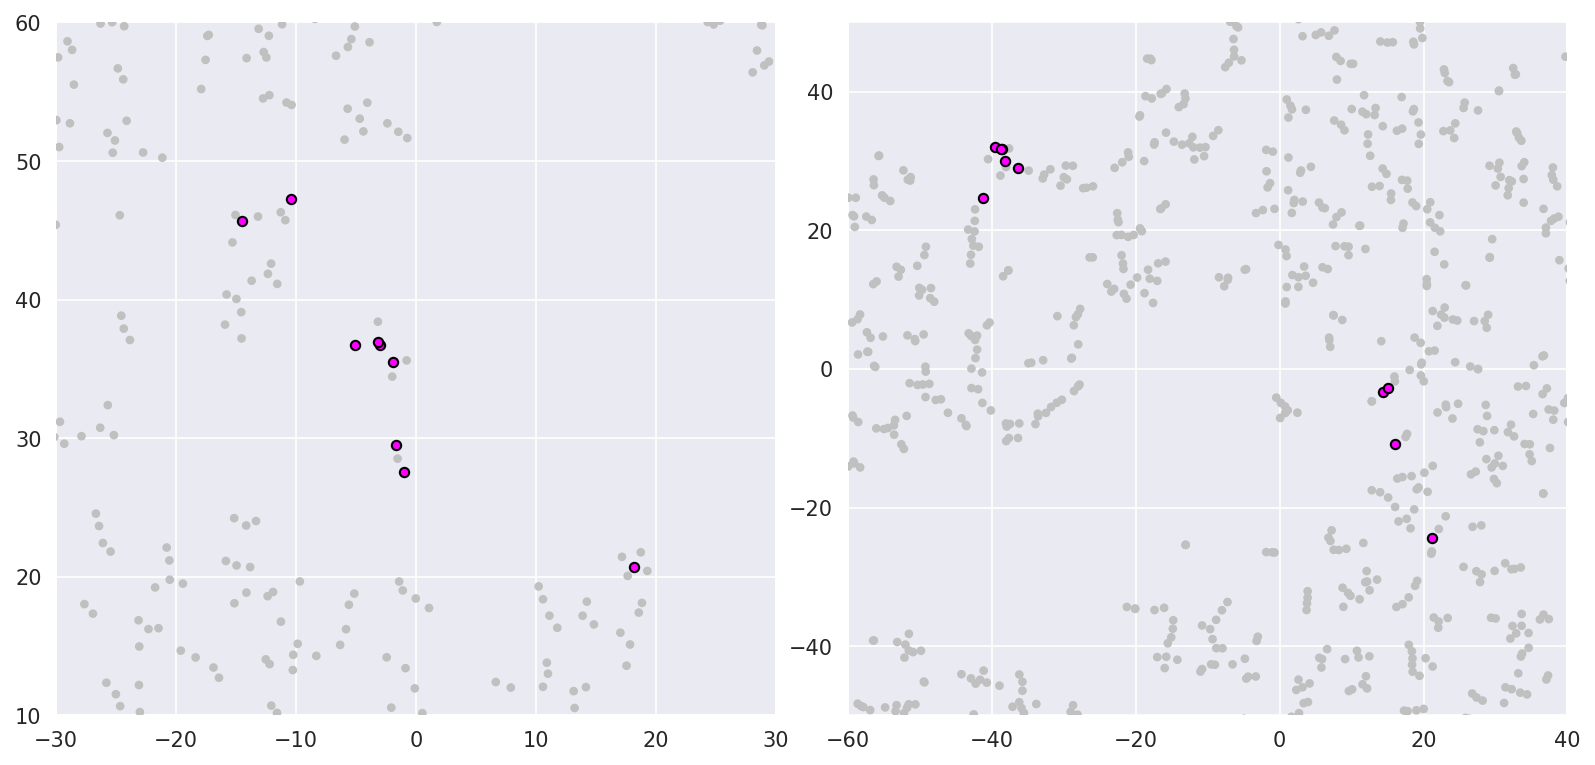

In [11]:
kwargs_plot_3= {"special_marker_color":"magenta", "color_limits":color_lim, "special_cases":EE_Lien16, "non_special_marker_color":'silver', "special_marker":["o"]*100, "legend_special_cases":False, 'marker_size':10, 'special_marker_size':20}
fig = plt.figure(figsize=[13, 6], dpi=150)
gs = fig.add_gridspec(ncols=2, nrows=1, wspace=0.1, hspace=0.1)
ax = gs.subplots()
ax[0] = swift_64ms.plot_tsne(pos_64ms[0], ax=ax[0], names=names_64ms, **kwargs_plot_3)
ax[1] = swift_64ms.plot_tsne(pos_fabada[0], ax=ax[1], names=names_fabada, **kwargs_plot_3)
ax[1].axis('on')
ax[0].set_xlim([-30, 30])
ax[0].set_ylim([10, 60])
ax[1].set_xlim([-60, 40])
ax[1].set_ylim([-50, 50])

In both cases, it is possible to discern about some GRBs thar are close to the EE GRBs from [Lien et al.(2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...829....7L/abstract). Let's see which GRBs are the nearest neighbors of these EE GRBs, and what are their properties.

# Example Case: 64 ms data without noise reduction

In the 64 ms data without noise reduction, it is possible to discern two little groups of EE GRBs mainly:

(40.0, 50.0)

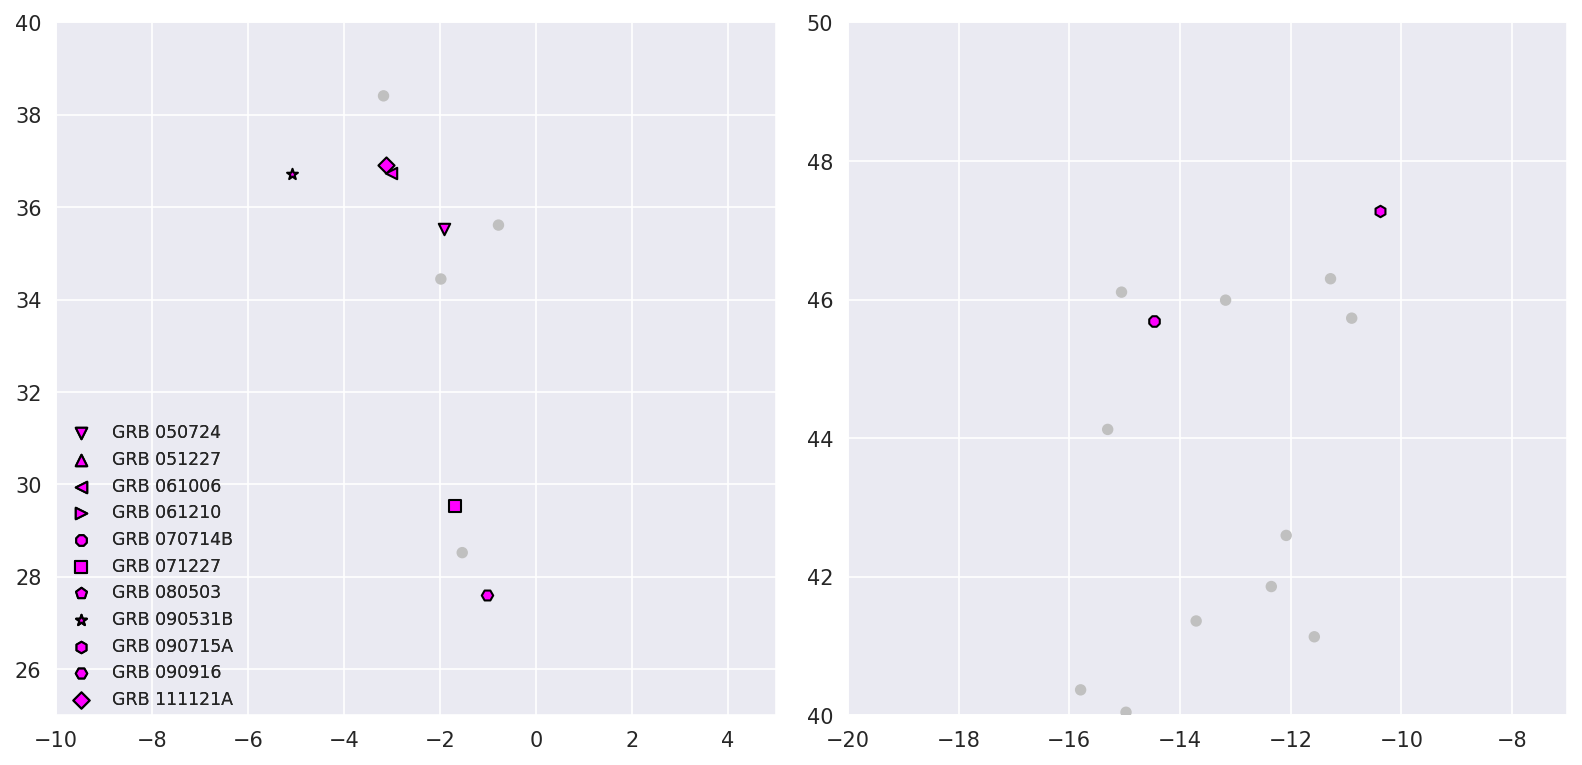

In [50]:
kwargs_plot_4= {"special_marker_color":"magenta", "color_limits":color_lim, "special_cases":EE_Lien16, "non_special_marker_color":'silver', 'marker_size':20, 'special_marker_size':30}
fig = plt.figure(figsize=[13, 6], dpi=150)
gs = fig.add_gridspec(ncols=2, nrows=1, wspace=0.1, hspace=0.1)
ax = gs.subplots()
ax[0] = swift_64ms.plot_tsne(pos_64ms[0], ax=ax[0], names=names_64ms, **kwargs_plot_4)
ax[1] = swift_64ms.plot_tsne(pos_64ms[0], ax=ax[1], names=names_64ms, legend_special_cases=False, **kwargs_plot_4)
ax[1].axis('on')
ax[0].set_xlim([-10, 5]); ax[0].set_ylim([25, 40])
ax[1].set_xlim([-20, -7]); ax[1].set_ylim([40, 50])

To find the nearest neighbors to these GRBs, you can use the `nearest_neighbors` function from `SWIFT`. This function receives as arguments the name of the GRB to use as reference (`name`), the embedding to use (`coord`), the number of neighbors to find (`num`), and the overall array of names associated with each element of the embedding (`total_names`). The function returns a list with the names of the nearest neighbors, and it is possible to sort them in ascendant order using the `sorted_d` flag.

Let's find the 6 nearest neighbors to the GRB 050724, as example (it will take all the GRBs from the upper group of the left scatter plot):

In [37]:
near_to_GRB0505724 = swift_64ms.nearest_neighbors(name="GRB050724", coord=pos_64ms[0], num=6, total_names=names_64ms, sorted_d=False)
print(f"Nearest neighbors to GRB050724: {near_to_GRB0505724}")
non_EE_Lien16 = [grb for grb in near_to_GRB0505724 if grb not in EE_Lien16]
print(f"Non EE GRBs in Lien et al.(2016): {non_EE_Lien16}")

Nearest neighbors to GRB050724: ['GRB061006' 'GRB090531B' 'GRB111121A' 'GRB180805B' 'GRB200219A'
 'GRB200716C']
Non EE GRBs in Lien et al.(2016): ['GRB180805B', 'GRB200219A', 'GRB200716C']


(25.0, 40.0)

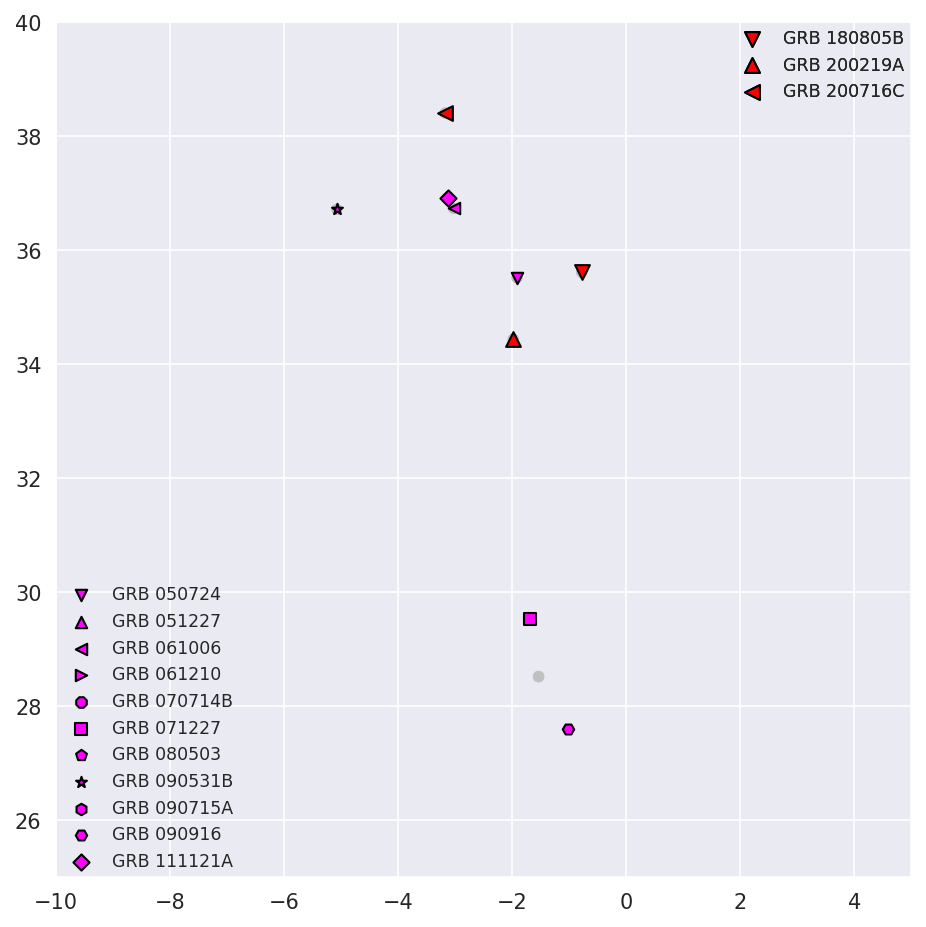

In [54]:
kwargs_plot_5= {"special_marker_color":"red", "color_limits":color_lim, "special_cases":non_EE_Lien16, "non_special_marker_color":'silver', 'marker_size':20, 'special_marker_size':50, "special_kwargs_legend":{"loc":"upper right"}}
fig, ax = plt.subplots(figsize=[6, 6], dpi=150)
ax = swift_64ms.plot_tsne(pos_64ms[0], ax=ax, names=names_64ms, **kwargs_plot_4)
ax = swift_64ms.plot_tsne(pos_64ms[0], ax=ax, names=names_64ms, **kwargs_plot_5)
ax.axis('on')
ax.set_xlim([-10, 5]); ax.set_ylim([25, 40])

Now, let's compare their associated Fourier Amplitude Spectrum by using the `dft_plot` function from `SWIFT`, and their light curves by using the `plot_any_GRB` function from `SWIFT`:

# GRB 050724

Text(0.5, 1.0, 'GRB050724 Fourier Amplitude Spectrum')

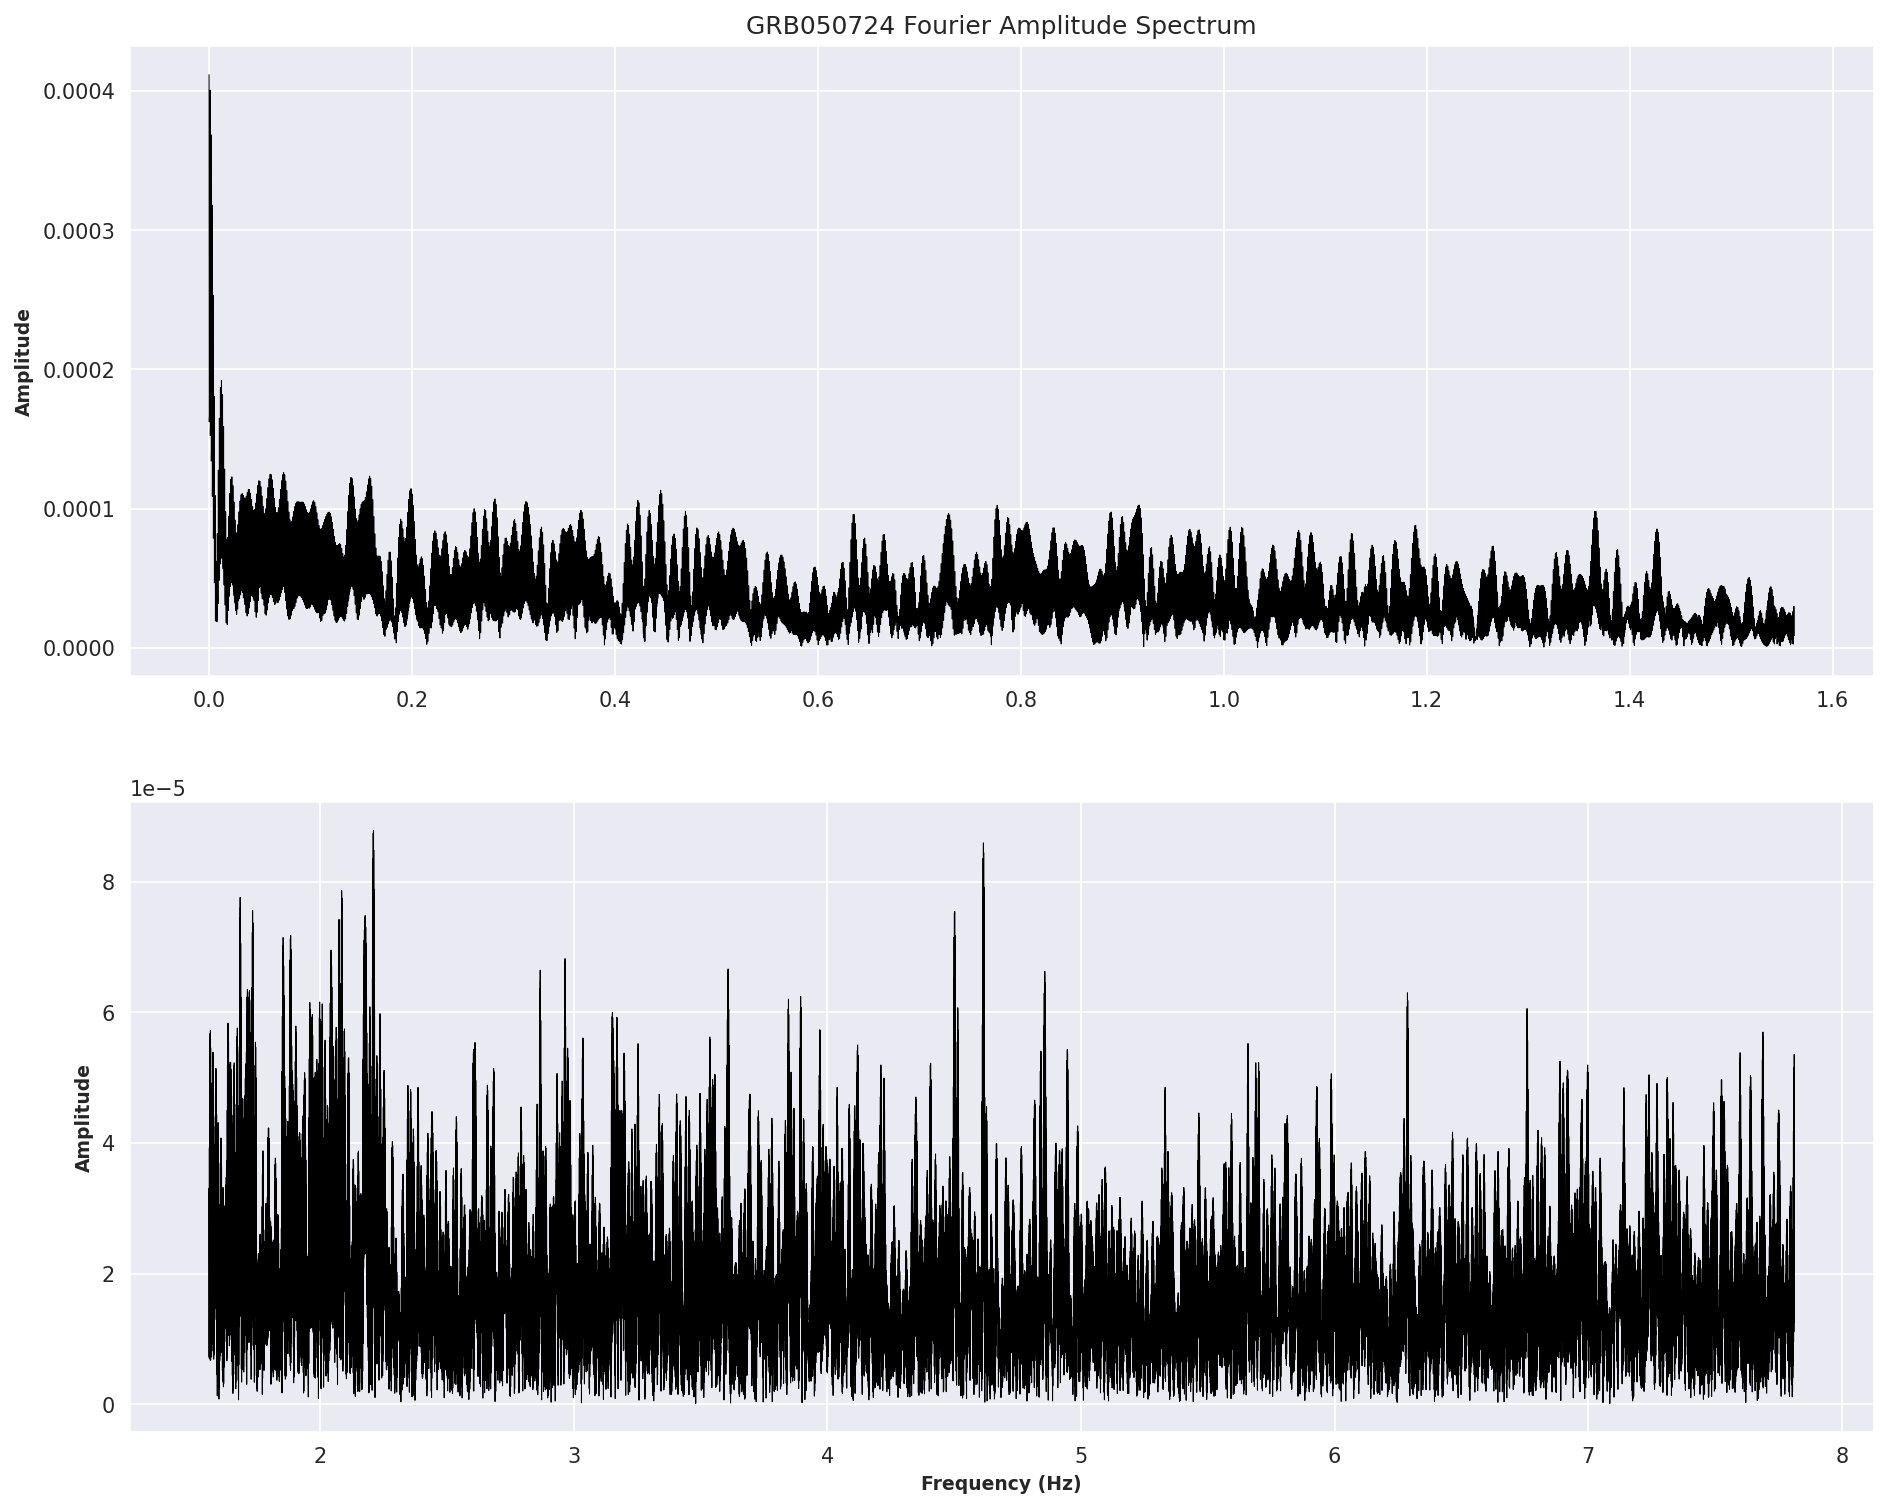

In [36]:
fig, ax = plt.subplots(2, 1, figsize=[15, 12], dpi=150)
index = np.where(names_64ms == "GRB050724")[0][0]
ax = swift_64ms.dft_plot(spectrum=features_64ms[index], ax=ax)
ax[0].set_title("GRB050724 Fourier Amplitude Spectrum")

array([<Axes: >, <Axes: >, <Axes: ylabel='Counts/sec/det'>, <Axes: >,
       <Axes: xlabel='Time since BAT Trigger time (s)'>], dtype=object)

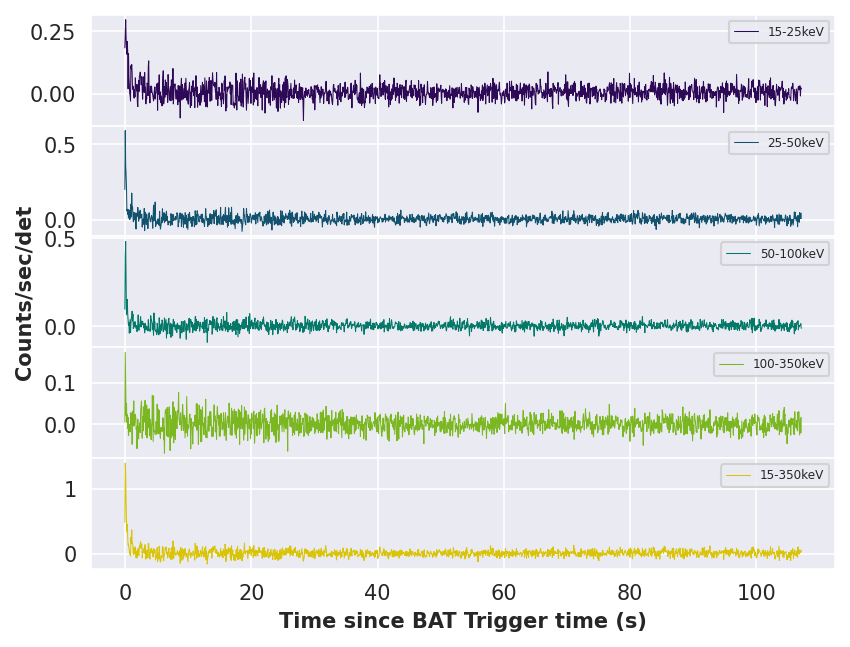

In [43]:
swift_64ms.plot_any_grb("GRB050724", t=100)

**Note: As you can notice, the identification of Extended emission over the noise levels is a challenging task, the Extended Emission is very tiny and can only be seen in some specific bands. This GRB has been flagged as Extended Emission previously!**

# GRB 180805B

Text(0.5, 1.0, 'GRB180805B Fourier Amplitude Spectrum')

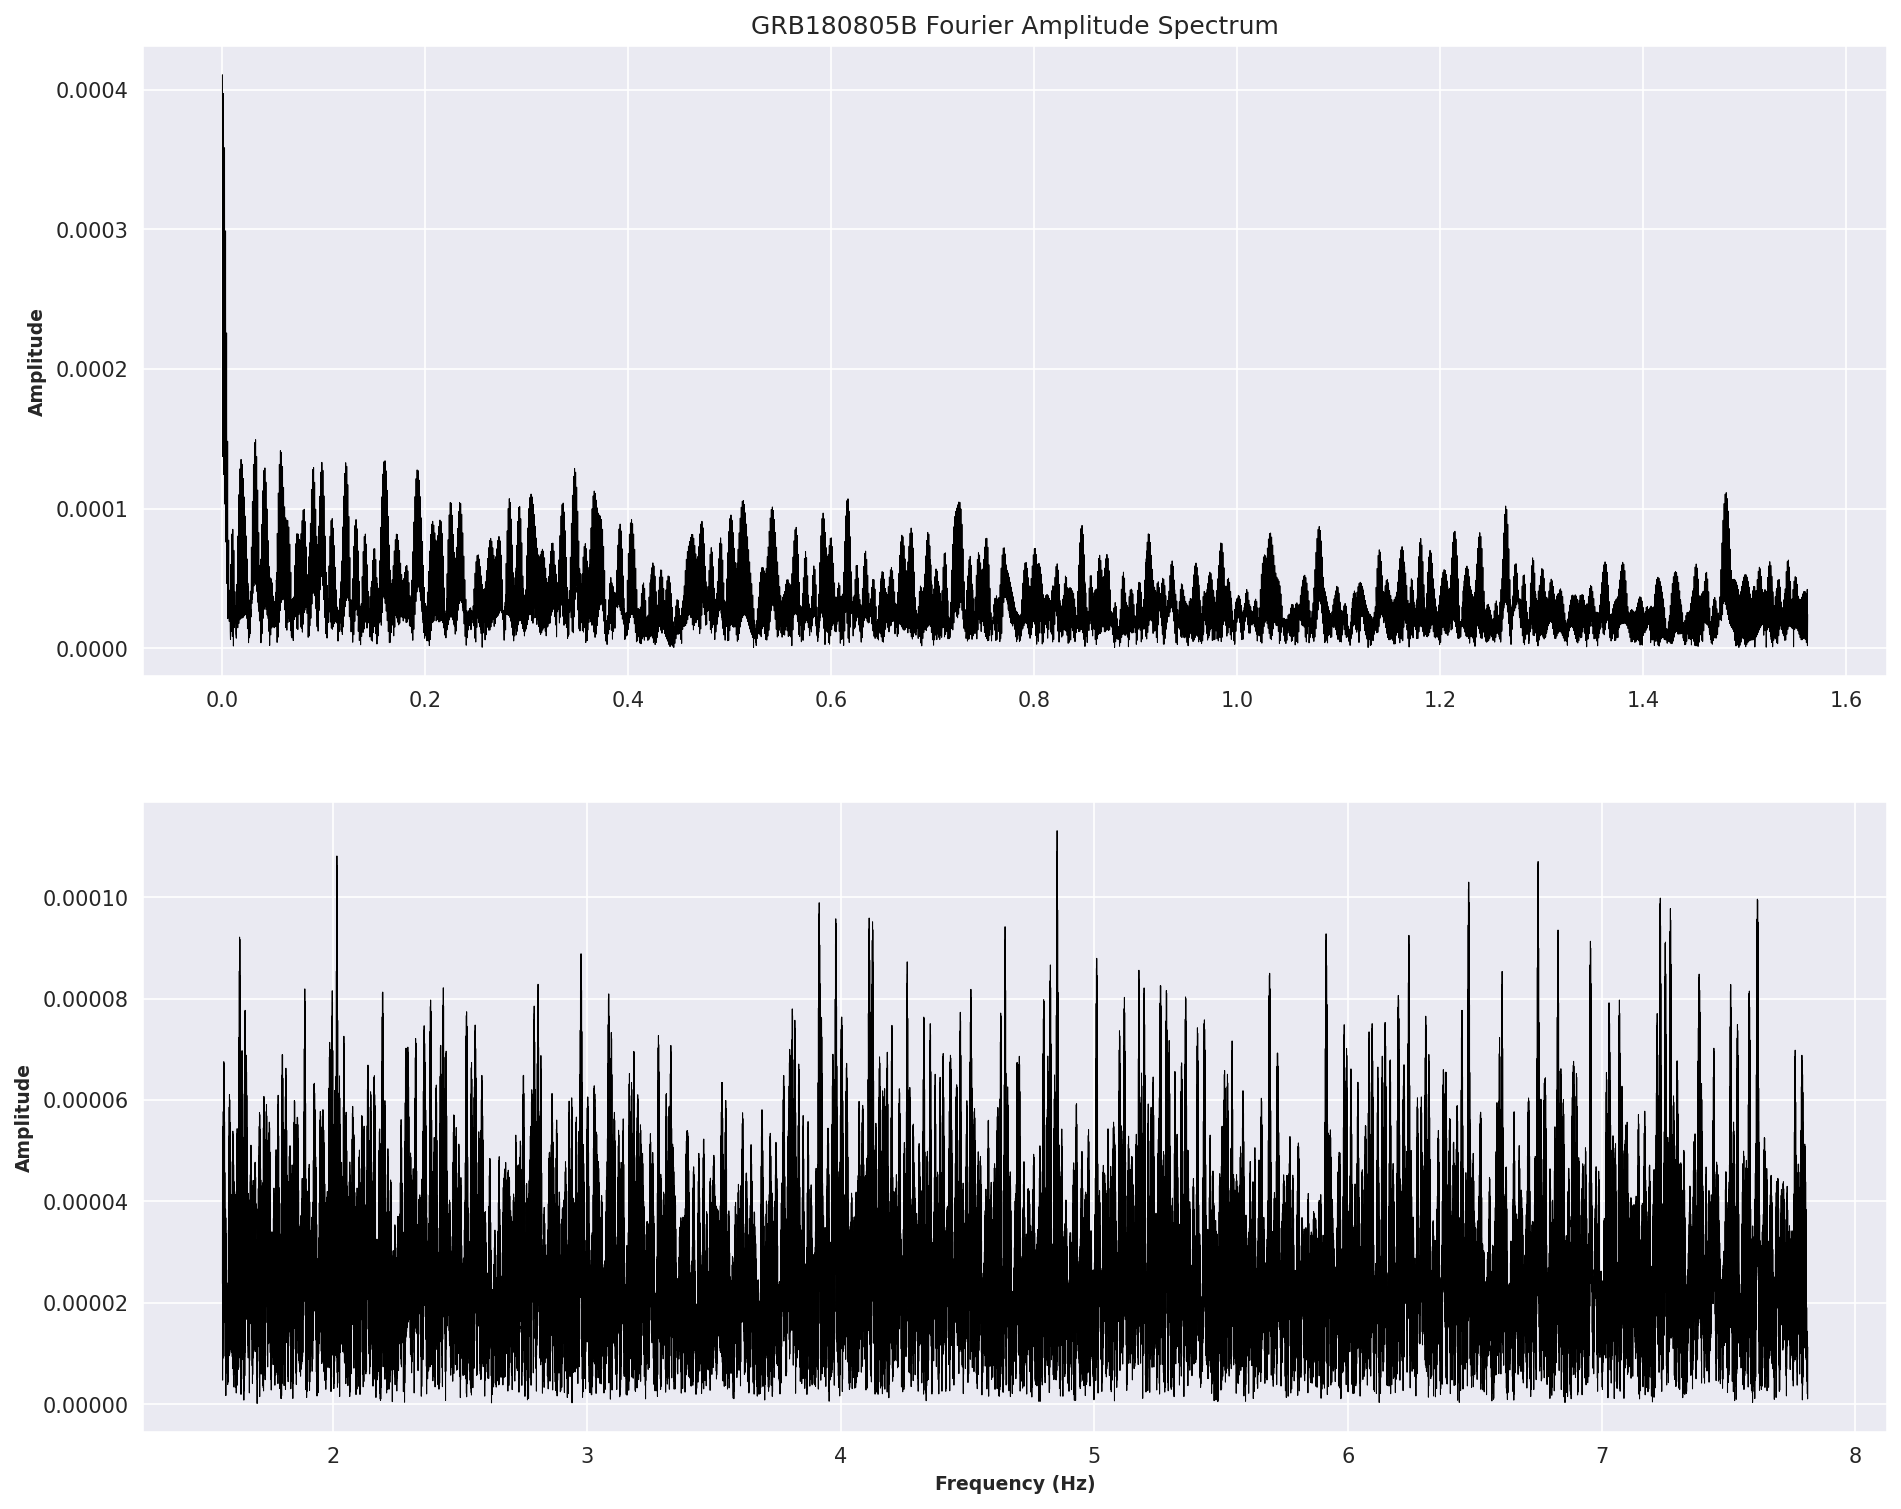

In [38]:
fig, ax = plt.subplots(2, 1, figsize=[15, 12], dpi=150)
index = np.where(names_64ms == non_EE_Lien16[0])[0][0]
ax = swift_64ms.dft_plot(spectrum=features_64ms[index], ax=ax)
ax[0].set_title(f"{non_EE_Lien16[0]} Fourier Amplitude Spectrum")

array([<Axes: >, <Axes: >, <Axes: ylabel='Counts/sec/det'>, <Axes: >,
       <Axes: xlabel='Time since BAT Trigger time (s)'>], dtype=object)

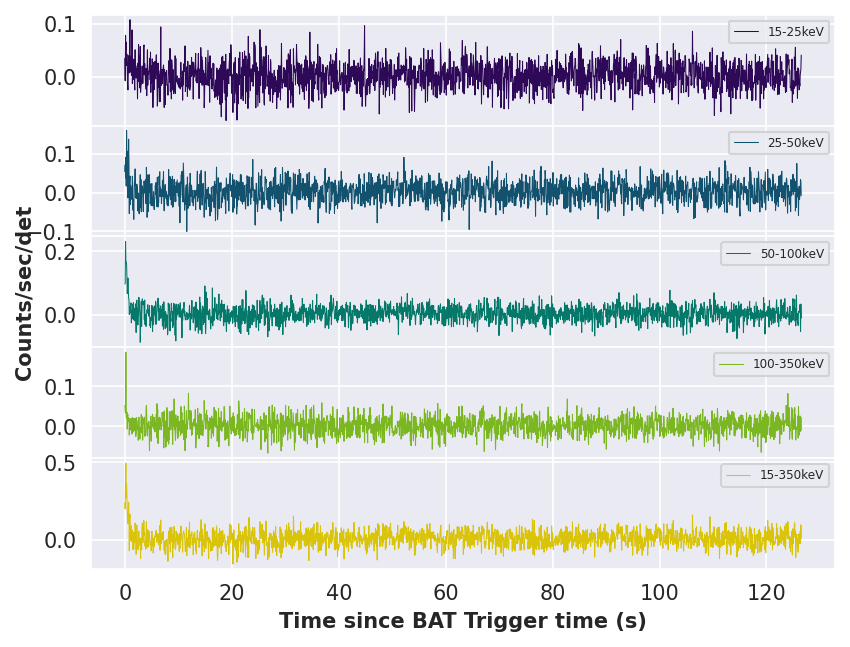

In [44]:
swift_64ms.plot_any_grb(non_EE_Lien16[0], t=100)

# GRB 200219A

Text(0.5, 1.0, 'GRB200219A Fourier Amplitude Spectrum')

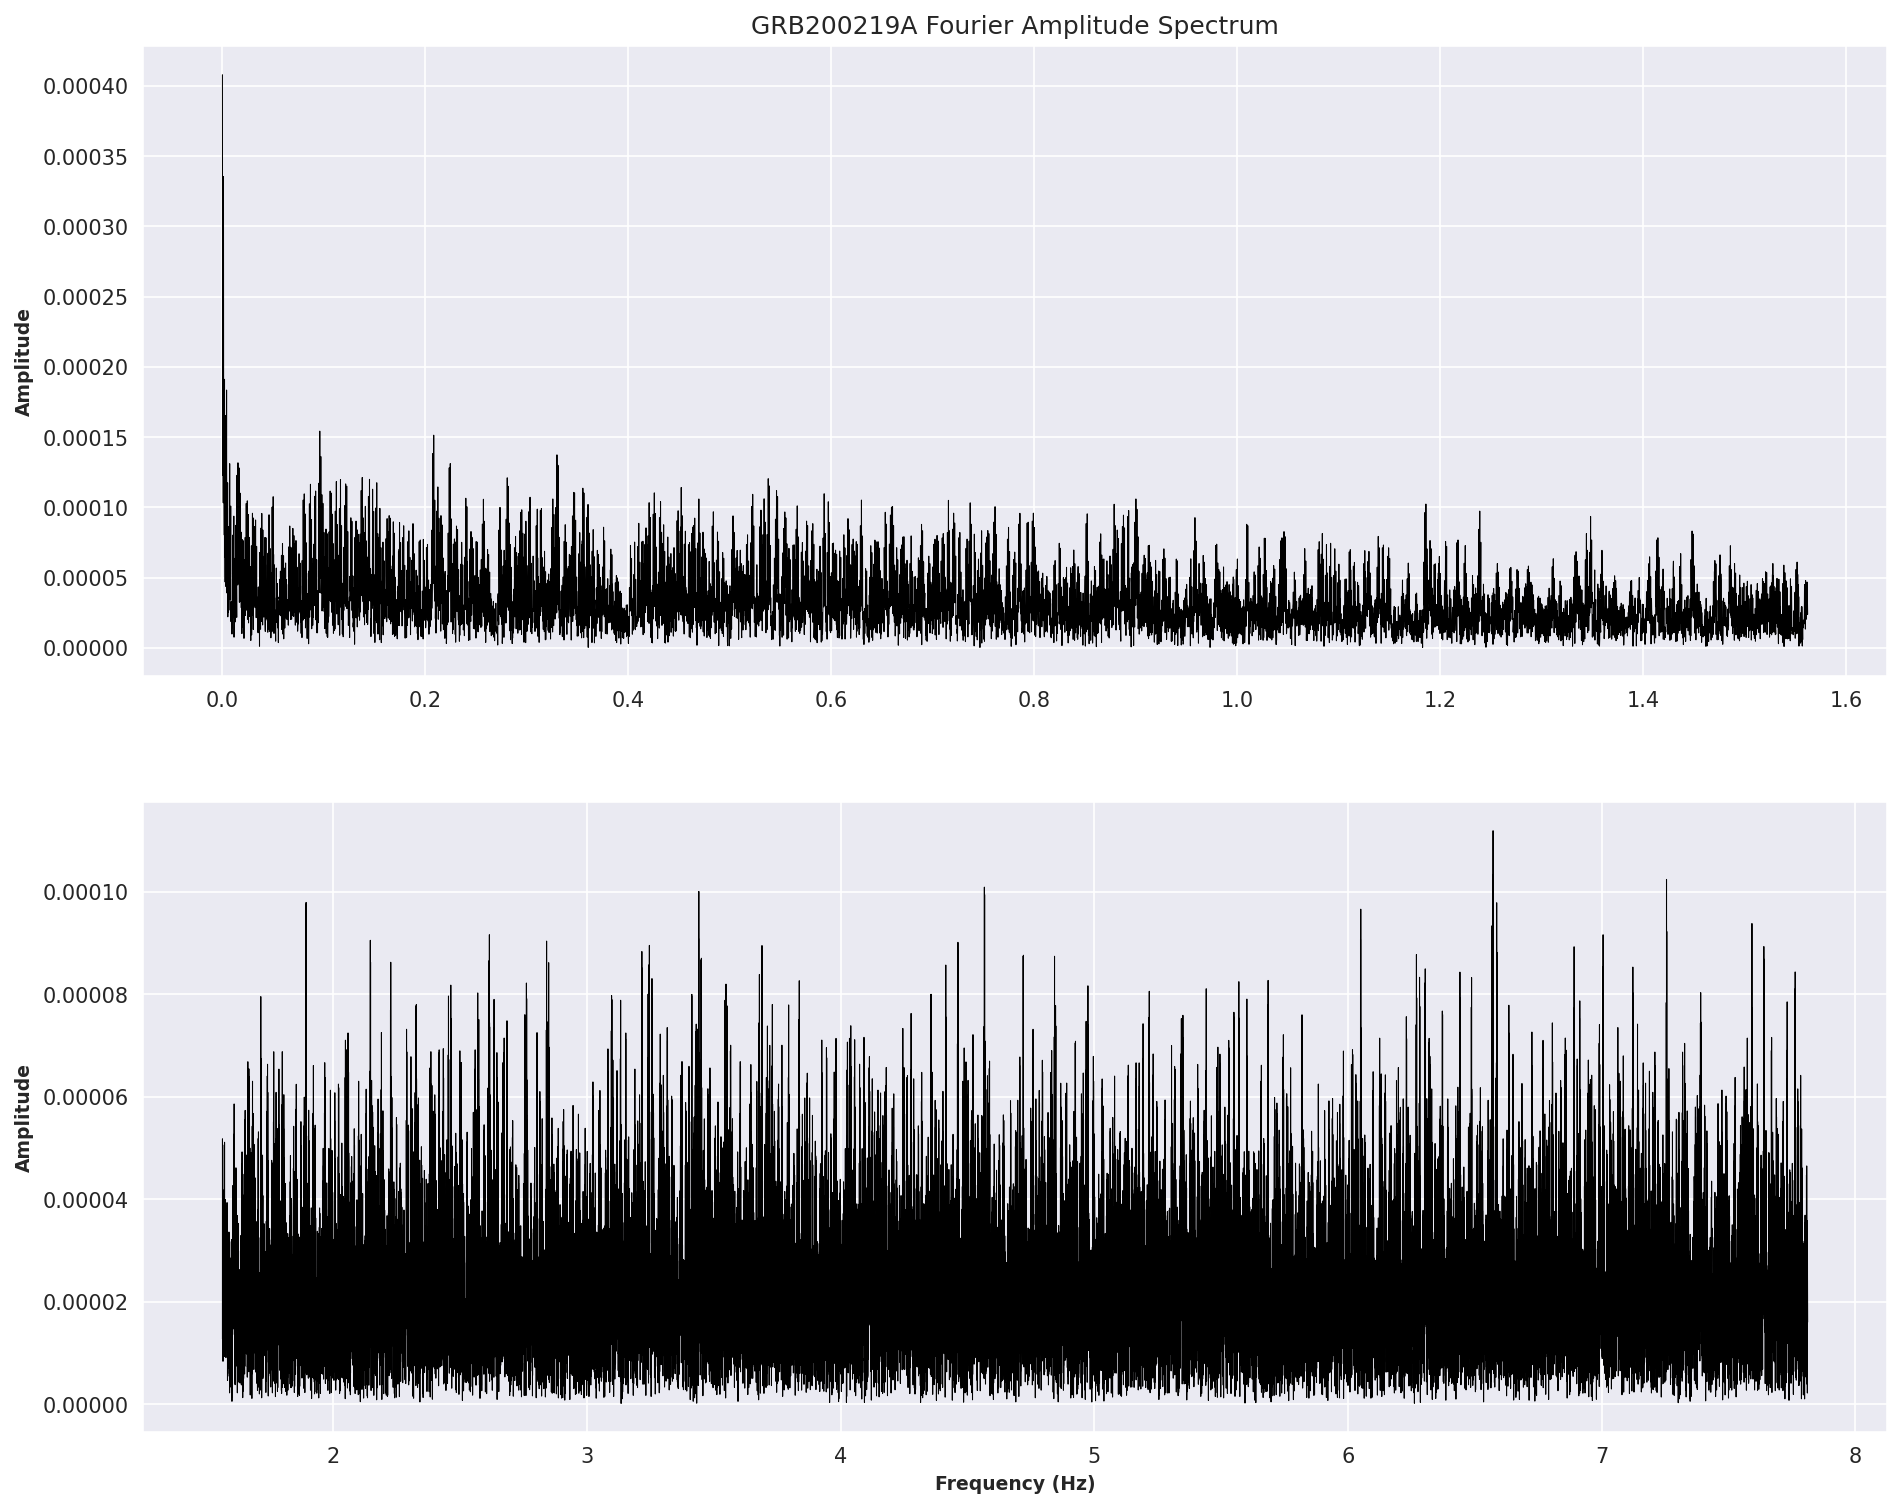

In [39]:
fig, ax = plt.subplots(2, 1, figsize=[15, 12], dpi=150)
index = np.where(names_64ms == non_EE_Lien16[1])[0][0]
ax = swift_64ms.dft_plot(spectrum=features_64ms[index], ax=ax)
ax[0].set_title(f"{non_EE_Lien16[1]} Fourier Amplitude Spectrum")

array([<Axes: >, <Axes: >, <Axes: ylabel='Counts/sec/det'>, <Axes: >,
       <Axes: xlabel='Time since BAT Trigger time (s)'>], dtype=object)

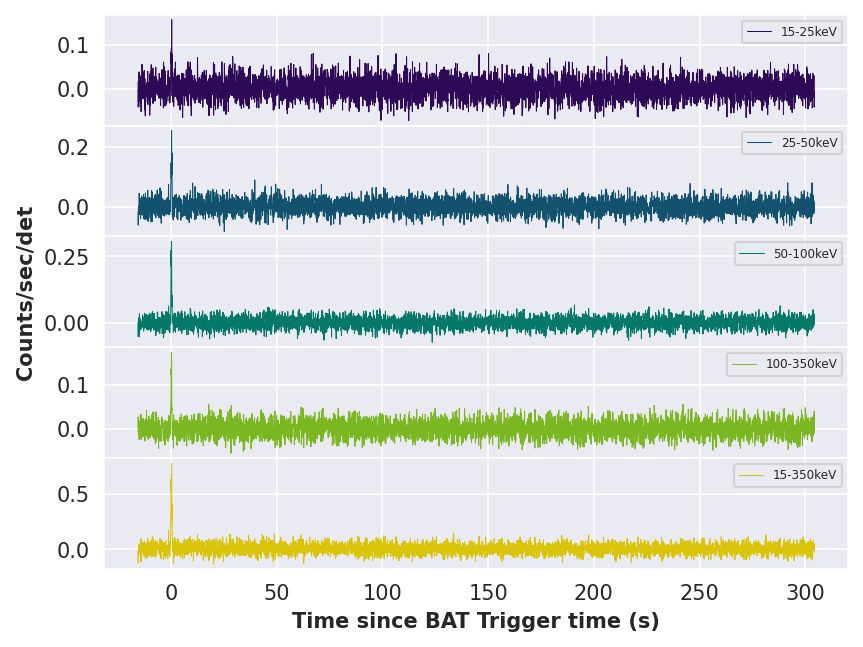

In [45]:
swift_64ms.plot_any_grb(non_EE_Lien16[1], t=100)

The Extended Emission identification present difficulties in the correct discernment over the noise levels, and it is only possible to see it in some specific bands. However, the Fourier Amplitude Spectrum of these GRBs shows a very similar behavior to GRB 050724. By using this method, it is possible to identify new candidates of EE GRBs that can be studied in more detail. The t-SNE technique is a powerful tool to identify patterns in high dimensional data, and it is very useful to reduce the effort of analyze the entire dataset looking for similarities between GRBs.

At this point, we highlight that the light curves are heavily pre-processed before the t-SNE embedding, and the Fourier Amplitude Spectrum is calculated from the pre-processed light curves. Therefore, a direct comparison of their light curves may not be useful in the interpretations and conclusions derived from a classification based on t-SNE. Moreover, t-SNE associates a cost function to placing every object in the embedding, looking for minimizing the total sum of the cost. Using a perplexity of 5 the algorithm computes 16 nearest neighbors, and it is possible that t-SNE attempts to place an outlier near to a cluster that is somewhat dissimilar, as explained by [Steinhardt et al.(2023)](https://iopscience.iop.org/article/10.3847/1538-4357/acb999). It is highly recommended the inspection of embeddings at different binning before categorize a GRB as a candidate of, for example, Extended Emission.